In [9]:
# Import the required libraries and dependencies
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [10]:
# Stock list
stock_list = [
                'XLK',
                'XLV',
                'XLE',
                'VNQ',
                'XLF',
                'XLB',
                'XLU',
                'XLI',
                'XLP',
                'XLY',
                'XTL',
              ]

# Define dictionary
stock_df = {}

# Loop through stocks 
for stock in stock_list:
    # Read the data into DataFrames
    df = pd.read_csv(f'Resources/{stock}.csv')
    df.set_index('Date', inplace=True)
    
    # Trim to last n years
    stock_df[stock] = df.iloc[-1777:]
    #stock_df[stock] = df.iloc[-2029:]
    #stock_df[stock] = df.iloc[-2520:]
    #stock_df[stock] = df.iloc[-2768:]
    
    # Confirm shape
    #print(f'{stock}',stock_df[stock].shape)

In [11]:
# Function to read and preprocess data
def preprocess_stock_data(stock):
    df = pd.read_csv(os.path.join('Resources', f'{stock}.csv'))
    df.set_index('Date', inplace=True)
    df = df.iloc[-1777:]
    df = df[['Adj Close']].rename(columns={'Adj Close': f'{stock}_Adj_Close'})
    
    # Calculate n-Day percent return features
    periods = [1, 2, 3, 5, 8, 13]
    for period in periods:
        df[f'{stock}_{period}Day_Return'] = df[f'{stock}_Adj_Close'].pct_change(periods=period)

    # Calculate 3-day rolling average on n-day return features
    for period in periods:
        df[f'{stock}_{period}D_3D_Avg'] = df[f'{stock}_{period}Day_Return'].rolling(window=3).mean()

    # Calculate polynomial features across averages
    for period in periods:
        df[f'{stock}_{period}D_Squared'] = df[f'{stock}_{period}D_3D_Avg'] ** 2

    # Calculate ratio features across averages
    df[f'{stock}_3D_1D_Ratio'] = df[f'{stock}_3D_3D_Avg'] / df[f'{stock}_1D_3D_Avg']
    df[f'{stock}_3D_2D_Ratio'] = df[f'{stock}_3D_3D_Avg'] * df[f'{stock}_2D_3D_Avg']
    df[f'{stock}_2D_1D_Ratio'] = df[f'{stock}_2D_3D_Avg'] * df[f'{stock}_1D_3D_Avg']
    
    df.dropna(inplace=True)
    return df

# Preprocess each stock and store in a dictionary
stock_df = {stock: preprocess_stock_data(stock) for stock in stock_list}

# Confirm shapes
for stock, df in stock_df.items():
    print(f'{stock}:', df.shape)

XLK: (1762, 22)
XLV: (1762, 22)
XLE: (1762, 22)
VNQ: (1762, 22)
XLF: (1762, 22)
XLB: (1762, 22)
XLU: (1762, 22)
XLI: (1762, 22)
XLP: (1762, 22)
XLY: (1762, 22)
XTL: (1762, 22)


In [12]:
# Concatenate all dataframes into one
concatenated_df = pd.concat(stock_df.values(), keys=stock_df.keys(), axis=1)

In [13]:
# Display columns
print(concatenated_df.columns)

MultiIndex([('XLK',    'XLK_Adj_Close'),
            ('XLK',  'XLK_1Day_Return'),
            ('XLK',  'XLK_2Day_Return'),
            ('XLK',  'XLK_3Day_Return'),
            ('XLK',  'XLK_5Day_Return'),
            ('XLK',  'XLK_8Day_Return'),
            ('XLK', 'XLK_13Day_Return'),
            ('XLK',    'XLK_1D_3D_Avg'),
            ('XLK',    'XLK_2D_3D_Avg'),
            ('XLK',    'XLK_3D_3D_Avg'),
            ...
            ('XTL',   'XTL_13D_3D_Avg'),
            ('XTL',   'XTL_1D_Squared'),
            ('XTL',   'XTL_2D_Squared'),
            ('XTL',   'XTL_3D_Squared'),
            ('XTL',   'XTL_5D_Squared'),
            ('XTL',   'XTL_8D_Squared'),
            ('XTL',  'XTL_13D_Squared'),
            ('XTL',  'XTL_3D_1D_Ratio'),
            ('XTL',  'XTL_3D_2D_Ratio'),
            ('XTL',  'XTL_2D_1D_Ratio')],
           length=242)


In [14]:
# Loop through stocks to drop unnecessary columns
for stock in stock_list:
    column_tuple = (stock, f'{stock}_Adj_Close')
    
    if column_tuple in concatenated_df.columns:
        concatenated_df.drop(columns=[column_tuple], inplace=True)
    else:
        print(f"Column '{column_tuple}' not found in concatenated dataframe.")

In [15]:
# Display df
concatenated_df

XLK                                                  \
           XLK_1Day_Return XLK_2Day_Return XLK_3Day_Return XLK_5Day_Return   
Date                                                                         
2017-06-23        0.006256        0.006615        0.012226        0.019005   
2017-06-26       -0.005329        0.000894        0.001252       -0.001248   
2017-06-27       -0.016429       -0.021670       -0.015550       -0.009709   
2017-06-28        0.012527       -0.004107       -0.009414       -0.002861   
2017-06-29       -0.017931       -0.005628       -0.021964       -0.021090   
...                    ...             ...             ...             ...   
2024-06-18        0.001255        0.016427        0.020236        0.051051   
2024-06-20       -0.011235       -0.009995        0.005007        0.016753   
2024-06-21       -0.001748       -0.012964       -0.011725        0.007010   
2024-06-24       -0.024516       -0.026222       -0.037163       -0.021346   
2024-06-25        0.018344       -0.006622       -0.008359       -0.018270   

                                                                         \
           XLK_8Day_Return XLK_13Day_Return XLK_1D_3D_Avg XLK_2D_3D_Avg   
Date                                                                      
2017-06-23        0.007788        -0.010558      0.004062      0.003350   
2017-06-26        0.007267        -0.018921      0.000428      0.004481   
2017-06-27       -0.004824        -0.037223     -0.005167     -0.004720   
2017-06-28        0.009412        -0.000452     -0.003077     -0.008294   
2017-06-29       -0.023185        -0.012557     -0.007277     -0.010468   
...                    ...              ...           ...           ...   
2024-06-18        0.075825         0.102845      0.006719      0.015691   
2024-06-20        0.061271         0.088742      0.001724      0.008463   
2024-06-21        0.056720         0.084105     -0.003910     -0.002177   
2024-06-24        0.011992         0.055322     -0.012500     -0.016394   
2024-06-25        0.008253         0.051327     -0.002640     -0.015269   

                                        ...            XTL                 \
           XLK_3D_3D_Avg XLK_5D_3D_Avg  ... XTL_13D_3D_Avg XTL_1D_Squared   
Date                                    ...                                 
2017-06-23      0.007464      0.011969  ...      -0.022902   1.102793e-05   
2017-06-26      0.003779      0.009550  ...      -0.017996   2.062571e-05   
2017-06-27     -0.000691      0.002682  ...      -0.023207   4.033309e-06   
2017-06-28     -0.007904     -0.004606  ...      -0.017195   1.103858e-06   
2017-06-29     -0.015643     -0.011220  ...      -0.019972   3.714876e-05   
...                  ...           ...  ...            ...            ...   
2024-06-18      0.027106      0.058764  ...       0.011883   3.008048e-07   
2024-06-20      0.017420      0.045687  ...       0.003322   1.258279e-06   
2024-06-21      0.004506      0.024938  ...      -0.009094   1.903319e-05   
2024-06-24     -0.014627      0.000806  ...      -0.016777   1.001593e-05   
2024-06-25     -0.019082     -0.010869  ...      -0.022615   7.117981e-07   

                                                                        \
           XTL_2D_Squared XTL_3D_Squared XTL_5D_Squared XTL_8D_Squared   
Date                                                                     
2017-06-23   3.991493e-07       0.000057   1.811916e-04       0.000133   
2017-06-26   6.176318e-05       0.000015   4.017865e-05       0.000118   
2017-06-27   6.547870e-06       0.000034   2.724389e-05       0.000155   
2017-06-28   9.681666e-06       0.000002   4.315761e-07       0.000148   
2017-06-29   5.280156e-05       0.000087   2.267232e-06       0.000243   
...                   ...            ...            ...            ...   
2024-06-18   7.324399e-07       0.000008   3.382252e-08       0.000309   
2024-06-20   2.559800e-06       0.000003   6.608985e-08     

In [16]:
# Reorder columns
# Extract the list of columns
columns = concatenated_df.columns

# Initialize lists for storing column groups
return_columns = []
other_columns = []

# Loop through the columns to separate them based on the pattern
for col in columns:
    if '_1Day_Return' in col[1]:
        return_columns.append(col)
    else:
        other_columns.append(col)

# Create a new column order
new_column_order = other_columns + return_columns

# Reindex the DataFrame
concatenated_df = concatenated_df.reindex(columns=new_column_order)

# Print the reordered columns to verify
print(concatenated_df.columns)

MultiIndex([('XLK',  'XLK_2Day_Return'),
            ('XLK',  'XLK_3Day_Return'),
            ('XLK',  'XLK_5Day_Return'),
            ('XLK',  'XLK_8Day_Return'),
            ('XLK', 'XLK_13Day_Return'),
            ('XLK',    'XLK_1D_3D_Avg'),
            ('XLK',    'XLK_2D_3D_Avg'),
            ('XLK',    'XLK_3D_3D_Avg'),
            ('XLK',    'XLK_5D_3D_Avg'),
            ('XLK',    'XLK_8D_3D_Avg'),
            ...
            ('XLV',  'XLV_1Day_Return'),
            ('XLE',  'XLE_1Day_Return'),
            ('VNQ',  'VNQ_1Day_Return'),
            ('XLF',  'XLF_1Day_Return'),
            ('XLB',  'XLB_1Day_Return'),
            ('XLU',  'XLU_1Day_Return'),
            ('XLI',  'XLI_1Day_Return'),
            ('XLP',  'XLP_1Day_Return'),
            ('XLY',  'XLY_1Day_Return'),
            ('XTL',  'XTL_1Day_Return')],
           length=231)


In [17]:
# Initialize lists for storing index positions
day1_column_indices = []

# Loop through the columns to find index positions based on the pattern
for idx, col in enumerate(concatenated_df.columns):
    if '_1Day_Return' in col[1]:  # Assuming col is a tuple (stock, column_name)
        day1_column_indices.append(idx)

# Example usage: Select columns based on index positions
day1_columns_to_rank = concatenated_df.columns[day1_column_indices]

# Example usage: Print the selected columns
print(day1_columns_to_rank)

MultiIndex([('XLK', 'XLK_1Day_Return'),
            ('XLV', 'XLV_1Day_Return'),
            ('XLE', 'XLE_1Day_Return'),
            ('VNQ', 'VNQ_1Day_Return'),
            ('XLF', 'XLF_1Day_Return'),
            ('XLB', 'XLB_1Day_Return'),
            ('XLU', 'XLU_1Day_Return'),
            ('XLI', 'XLI_1Day_Return'),
            ('XLP', 'XLP_1Day_Return'),
            ('XLY', 'XLY_1Day_Return'),
            ('XTL', 'XTL_1Day_Return')],
           )


In [18]:
# Initialize lists for storing index positions
day2_column_indices = []

# Loop through the columns to find index positions based on the pattern
for idx, col in enumerate(concatenated_df.columns):
    if '_2Day_Return' in col[1]:  # Assuming col is a tuple (stock, column_name)
        day2_column_indices.append(idx)

# Example usage: Select columns based on index positions
day2_columns_to_rank = concatenated_df.columns[day2_column_indices]

# Example usage: Print the selected columns
print(day2_columns_to_rank)

MultiIndex([('XLK', 'XLK_2Day_Return'),
            ('XLV', 'XLV_2Day_Return'),
            ('XLE', 'XLE_2Day_Return'),
            ('VNQ', 'VNQ_2Day_Return'),
            ('XLF', 'XLF_2Day_Return'),
            ('XLB', 'XLB_2Day_Return'),
            ('XLU', 'XLU_2Day_Return'),
            ('XLI', 'XLI_2Day_Return'),
            ('XLP', 'XLP_2Day_Return'),
            ('XLY', 'XLY_2Day_Return'),
            ('XTL', 'XTL_2Day_Return')],
           )


In [19]:
# Initialize lists for storing index positions
day3_column_indices = []

# Loop through the columns to find index positions based on the pattern
for idx, col in enumerate(concatenated_df.columns):
    if '_3Day_Return' in col[1]:  # Assuming col is a tuple (stock, column_name)
        day3_column_indices.append(idx)

# Example usage: Select columns based on index positions
day3_columns_to_rank = concatenated_df.columns[day3_column_indices]

# Example usage: Print the selected columns
print(day3_columns_to_rank)

MultiIndex([('XLK', 'XLK_3Day_Return'),
            ('XLV', 'XLV_3Day_Return'),
            ('XLE', 'XLE_3Day_Return'),
            ('VNQ', 'VNQ_3Day_Return'),
            ('XLF', 'XLF_3Day_Return'),
            ('XLB', 'XLB_3Day_Return'),
            ('XLU', 'XLU_3Day_Return'),
            ('XLI', 'XLI_3Day_Return'),
            ('XLP', 'XLP_3Day_Return'),
            ('XLY', 'XLY_3Day_Return'),
            ('XTL', 'XTL_3Day_Return')],
           )


In [20]:
# Initialize lists for storing index positions
day1_3_avg_column_indices = []

# Loop through the columns to find index positions based on the pattern
for idx, col in enumerate(concatenated_df.columns):
    if '_1D_3D_Avg' in col[1]:  # Assuming col is a tuple (stock, column_name)
        day1_3_avg_column_indices.append(idx)

# Example usage: Select columns based on index positions
day1_3_avg_columns_to_rank = concatenated_df.columns[day1_3_avg_column_indices]

# Example usage: Print the selected columns
print(day1_3_avg_columns_to_rank)

MultiIndex([('XLK', 'XLK_1D_3D_Avg'),
            ('XLV', 'XLV_1D_3D_Avg'),
            ('XLE', 'XLE_1D_3D_Avg'),
            ('VNQ', 'VNQ_1D_3D_Avg'),
            ('XLF', 'XLF_1D_3D_Avg'),
            ('XLB', 'XLB_1D_3D_Avg'),
            ('XLU', 'XLU_1D_3D_Avg'),
            ('XLI', 'XLI_1D_3D_Avg'),
            ('XLP', 'XLP_1D_3D_Avg'),
            ('XLY', 'XLY_1D_3D_Avg'),
            ('XTL', 'XTL_1D_3D_Avg')],
           )


In [21]:
# Initialize lists for storing index positions
day2_3_avg_column_indices = []

# Loop through the columns to find index positions based on the pattern
for idx, col in enumerate(concatenated_df.columns):
    if '_2D_3D_Avg' in col[1]:  # Assuming col is a tuple (stock, column_name)
        day2_3_avg_column_indices.append(idx)

# Example usage: Select columns based on index positions
day2_3_avg_columns_to_rank = concatenated_df.columns[day2_3_avg_column_indices]

# Example usage: Print the selected columns
print(day2_3_avg_columns_to_rank)

MultiIndex([('XLK', 'XLK_2D_3D_Avg'),
            ('XLV', 'XLV_2D_3D_Avg'),
            ('XLE', 'XLE_2D_3D_Avg'),
            ('VNQ', 'VNQ_2D_3D_Avg'),
            ('XLF', 'XLF_2D_3D_Avg'),
            ('XLB', 'XLB_2D_3D_Avg'),
            ('XLU', 'XLU_2D_3D_Avg'),
            ('XLI', 'XLI_2D_3D_Avg'),
            ('XLP', 'XLP_2D_3D_Avg'),
            ('XLY', 'XLY_2D_3D_Avg'),
            ('XTL', 'XTL_2D_3D_Avg')],
           )


In [22]:
# Initialize lists for storing index positions
day3_3_avg_column_indices = []

# Loop through the columns to find index positions based on the pattern
for idx, col in enumerate(concatenated_df.columns):
    if '_3D_3D_Avg' in col[1]:  # Assuming col is a tuple (stock, column_name)
        day3_3_avg_column_indices.append(idx)

# Example usage: Select columns based on index positions
day3_3_avg_columns_to_rank = concatenated_df.columns[day3_3_avg_column_indices]

# Example usage: Print the selected columns
print(day3_3_avg_columns_to_rank)

MultiIndex([('XLK', 'XLK_3D_3D_Avg'),
            ('XLV', 'XLV_3D_3D_Avg'),
            ('XLE', 'XLE_3D_3D_Avg'),
            ('VNQ', 'VNQ_3D_3D_Avg'),
            ('XLF', 'XLF_3D_3D_Avg'),
            ('XLB', 'XLB_3D_3D_Avg'),
            ('XLU', 'XLU_3D_3D_Avg'),
            ('XLI', 'XLI_3D_3D_Avg'),
            ('XLP', 'XLP_3D_3D_Avg'),
            ('XLY', 'XLY_3D_3D_Avg'),
            ('XTL', 'XTL_3D_3D_Avg')],
           )


In [23]:
# Initialize lists for storing index positions
day3_1_ratio_column_indices = []

# Loop through the columns to find index positions based on the pattern
for idx, col in enumerate(concatenated_df.columns):
    if '_3D_1D_Ratio' in col[1]:  # Assuming col is a tuple (stock, column_name)
        day3_1_ratio_column_indices.append(idx)

# Example usage: Select columns based on index positions
day3_1_ratio_columns_to_rank = concatenated_df.columns[day3_1_ratio_column_indices]

# Example usage: Print the selected columns
print(day3_1_ratio_columns_to_rank)

MultiIndex([('XLK', 'XLK_3D_1D_Ratio'),
            ('XLV', 'XLV_3D_1D_Ratio'),
            ('XLE', 'XLE_3D_1D_Ratio'),
            ('VNQ', 'VNQ_3D_1D_Ratio'),
            ('XLF', 'XLF_3D_1D_Ratio'),
            ('XLB', 'XLB_3D_1D_Ratio'),
            ('XLU', 'XLU_3D_1D_Ratio'),
            ('XLI', 'XLI_3D_1D_Ratio'),
            ('XLP', 'XLP_3D_1D_Ratio'),
            ('XLY', 'XLY_3D_1D_Ratio'),
            ('XTL', 'XTL_3D_1D_Ratio')],
           )


In [24]:
# Initialize lists for storing index positions
day3_2_ratio_column_indices = []

# Loop through the columns to find index positions based on the pattern
for idx, col in enumerate(concatenated_df.columns):
    if '_3D_2D_Ratio' in col[1]:  # Assuming col is a tuple (stock, column_name)
        day3_2_ratio_column_indices.append(idx)

# Example usage: Select columns based on index positions
day3_2_ratio_columns_to_rank = concatenated_df.columns[day3_2_ratio_column_indices]

# Example usage: Print the selected columns
print(day3_2_ratio_columns_to_rank)

MultiIndex([('XLK', 'XLK_3D_2D_Ratio'),
            ('XLV', 'XLV_3D_2D_Ratio'),
            ('XLE', 'XLE_3D_2D_Ratio'),
            ('VNQ', 'VNQ_3D_2D_Ratio'),
            ('XLF', 'XLF_3D_2D_Ratio'),
            ('XLB', 'XLB_3D_2D_Ratio'),
            ('XLU', 'XLU_3D_2D_Ratio'),
            ('XLI', 'XLI_3D_2D_Ratio'),
            ('XLP', 'XLP_3D_2D_Ratio'),
            ('XLY', 'XLY_3D_2D_Ratio'),
            ('XTL', 'XTL_3D_2D_Ratio')],
           )


In [25]:
# Initialize lists for storing index positions
day2_1_ratio_column_indices = []

# Loop through the columns to find index positions based on the pattern
for idx, col in enumerate(concatenated_df.columns):
    if '_2D_1D_Ratio' in col[1]:  # Assuming col is a tuple (stock, column_name)
        day2_1_ratio_column_indices.append(idx)

# Example usage: Select columns based on index positions
day2_1_ratio_columns_to_rank = concatenated_df.columns[day2_1_ratio_column_indices]

# Example usage: Print the selected columns
print(day2_1_ratio_columns_to_rank)

MultiIndex([('XLK', 'XLK_2D_1D_Ratio'),
            ('XLV', 'XLV_2D_1D_Ratio'),
            ('XLE', 'XLE_2D_1D_Ratio'),
            ('VNQ', 'VNQ_2D_1D_Ratio'),
            ('XLF', 'XLF_2D_1D_Ratio'),
            ('XLB', 'XLB_2D_1D_Ratio'),
            ('XLU', 'XLU_2D_1D_Ratio'),
            ('XLI', 'XLI_2D_1D_Ratio'),
            ('XLP', 'XLP_2D_1D_Ratio'),
            ('XLY', 'XLY_2D_1D_Ratio'),
            ('XTL', 'XTL_2D_1D_Ratio')],
           )


In [26]:
# Initialize lists for storing index positions
day1_squared_column_indices = []

# Loop through the columns to find index positions based on the pattern
for idx, col in enumerate(concatenated_df.columns):
    if '_1D_Squared' in col[1]:  # Assuming col is a tuple (stock, column_name)
        day1_squared_column_indices.append(idx)

# Example usage: Select columns based on index positions
day1_squared_columns_to_rank = concatenated_df.columns[day1_squared_column_indices]

# Example usage: Print the selected columns
print(day1_squared_columns_to_rank)

MultiIndex([('XLK', 'XLK_1D_Squared'),
            ('XLV', 'XLV_1D_Squared'),
            ('XLE', 'XLE_1D_Squared'),
            ('VNQ', 'VNQ_1D_Squared'),
            ('XLF', 'XLF_1D_Squared'),
            ('XLB', 'XLB_1D_Squared'),
            ('XLU', 'XLU_1D_Squared'),
            ('XLI', 'XLI_1D_Squared'),
            ('XLP', 'XLP_1D_Squared'),
            ('XLY', 'XLY_1D_Squared'),
            ('XTL', 'XTL_1D_Squared')],
           )


In [27]:
# Initialize lists for storing index positions
day2_squared_column_indices = []

# Loop through the columns to find index positions based on the pattern
for idx, col in enumerate(concatenated_df.columns):
    if '_2D_Squared' in col[1]:  # Assuming col is a tuple (stock, column_name)
        day2_squared_column_indices.append(idx)

# Example usage: Select columns based on index positions
day2_squared_columns_to_rank = concatenated_df.columns[day2_squared_column_indices]

# Example usage: Print the selected columns
print(day2_squared_columns_to_rank)

MultiIndex([('XLK', 'XLK_2D_Squared'),
            ('XLV', 'XLV_2D_Squared'),
            ('XLE', 'XLE_2D_Squared'),
            ('VNQ', 'VNQ_2D_Squared'),
            ('XLF', 'XLF_2D_Squared'),
            ('XLB', 'XLB_2D_Squared'),
            ('XLU', 'XLU_2D_Squared'),
            ('XLI', 'XLI_2D_Squared'),
            ('XLP', 'XLP_2D_Squared'),
            ('XLY', 'XLY_2D_Squared'),
            ('XTL', 'XTL_2D_Squared')],
           )


In [28]:
# Initialize lists for storing index positions
day3_squared_column_indices = []

# Loop through the columns to find index positions based on the pattern
for idx, col in enumerate(concatenated_df.columns):
    if '_3D_Squared' in col[1]:  # Assuming col is a tuple (stock, column_name)
        day3_squared_column_indices.append(idx)

# Example usage: Select columns based on index positions
day3_squared_columns_to_rank = concatenated_df.columns[day3_squared_column_indices]

# Example usage: Print the selected columns
print(day3_squared_columns_to_rank)

MultiIndex([('XLK', 'XLK_3D_Squared'),
            ('XLV', 'XLV_3D_Squared'),
            ('XLE', 'XLE_3D_Squared'),
            ('VNQ', 'VNQ_3D_Squared'),
            ('XLF', 'XLF_3D_Squared'),
            ('XLB', 'XLB_3D_Squared'),
            ('XLU', 'XLU_3D_Squared'),
            ('XLI', 'XLI_3D_Squared'),
            ('XLP', 'XLP_3D_Squared'),
            ('XLY', 'XLY_3D_Squared'),
            ('XTL', 'XTL_3D_Squared')],
           )


In [29]:
# Apply lambda to rank columns by row
#concatenated_df[day1_columns_to_rank] = concatenated_df[day1_columns_to_rank].apply(lambda row: row.rank(ascending=True, method='min').astype(int), axis=1)
#concatenated_df[day2_columns_to_rank] = concatenated_df[day2_columns_to_rank].apply(lambda row: row.rank(ascending=True, method='min').astype(int), axis=1)
#concatenated_df[day3_columns_to_rank] = concatenated_df[day3_columns_to_rank].apply(lambda row: row.rank(ascending=True, method='min').astype(int), axis=1)

#concatenated_df[day1_3_avg_columns_to_rank] = concatenated_df[day1_3_avg_columns_to_rank].apply(lambda row: row.rank(ascending=True, method='min').astype(int), axis=1)
#concatenated_df[day2_3_avg_columns_to_rank] = concatenated_df[day2_3_avg_columns_to_rank].apply(lambda row: row.rank(ascending=True, method='min').astype(int), axis=1)
#concatenated_df[day3_3_avg_columns_to_rank] = concatenated_df[day3_3_avg_columns_to_rank].apply(lambda row: row.rank(ascending=True, method='min').astype(int), axis=1)

#concatenated_df[day3_1_ratio_columns_to_rank] = concatenated_df[day3_1_ratio_columns_to_rank].apply(lambda row: row.rank(ascending=True, method='min').astype(int), axis=1)
#concatenated_df[day3_2_ratio_columns_to_rank] = concatenated_df[day3_2_ratio_columns_to_rank].apply(lambda row: row.rank(ascending=True, method='min').astype(int), axis=1)
#concatenated_df[day2_1_ratio_columns_to_rank] = concatenated_df[day2_1_ratio_columns_to_rank].apply(lambda row: row.rank(ascending=True, method='min').astype(int), axis=1)

#concatenated_df[day1_squared_columns_to_rank] = concatenated_df[day1_squared_columns_to_rank].apply(lambda row: row.rank(ascending=True, method='min').astype(int), axis=1)
#concatenated_df[day2_squared_columns_to_rank] = concatenated_df[day2_squared_columns_to_rank].apply(lambda row: row.rank(ascending=True, method='min').astype(int), axis=1)
#concatenated_df[day3_squared_columns_to_rank] = concatenated_df[day3_squared_columns_to_rank].apply(lambda row: row.rank(ascending=True, method='min').astype(int), axis=1)

In [30]:
# Display df
concatenated_df

XLK                                                  \
           XLK_2Day_Return XLK_3Day_Return XLK_5Day_Return XLK_8Day_Return   
Date                                                                         
2017-06-23        0.006615        0.012226        0.019005        0.007788   
2017-06-26        0.000894        0.001252       -0.001248        0.007267   
2017-06-27       -0.021670       -0.015550       -0.009709       -0.004824   
2017-06-28       -0.004107       -0.009414       -0.002861        0.009412   
2017-06-29       -0.005628       -0.021964       -0.021090       -0.023185   
...                    ...             ...             ...             ...   
2024-06-18        0.016427        0.020236        0.051051        0.075825   
2024-06-20       -0.009995        0.005007        0.016753        0.061271   
2024-06-21       -0.012964       -0.011725        0.007010        0.056720   
2024-06-24       -0.026222       -0.037163       -0.021346        0.011992   
2024-06-25       -0.006622       -0.008359       -0.018270        0.008253   

                                                                       \
           XLK_13Day_Return XLK_1D_3D_Avg XLK_2D_3D_Avg XLK_3D_3D_Avg   
Date                                                                    
2017-06-23        -0.010558      0.004062      0.003350      0.007464   
2017-06-26        -0.018921      0.000428      0.004481      0.003779   
2017-06-27        -0.037223     -0.005167     -0.004720     -0.000691   
2017-06-28        -0.000452     -0.003077     -0.008294     -0.007904   
2017-06-29        -0.012557     -0.007277     -0.010468     -0.015643   
...                     ...           ...           ...           ...   
2024-06-18         0.102845      0.006719      0.015691      0.027106   
2024-06-20         0.088742      0.001724      0.008463      0.017420   
2024-06-21         0.084105     -0.003910     -0.002177      0.004506   
2024-06-24         0.055322     -0.012500     -0.016394     -0.014627   
2024-06-25         0.051327     -0.002640     -0.015269     -0.019082   

                                        ...             XLV             XLE  \
           XLK_5D_3D_Avg XLK_8D_3D_Avg  ... XLV_1Day_Return XLE_1Day_Return   
Date                                    ...                                   
2017-06-23      0.011969      0.006307  ...       -0.001489        0.006724   
2017-06-26      0.009550      0.007924  ...       -0.000994       -0.002174   
2017-06-27      0.002682      0.003410  ...       -0.009080       -0.001557   
2017-06-28     -0.004606      0.003951  ...        0.005273        0.005457   
2017-06-29     -0.011220     -0.006199  ...       -0.009116        0.002171   
...                  ...           ...  ...             ...             ...   
2024-06-18      0.058764      0.075019  ...        0.001304        0.004192   
2024-06-20      0.045687      0.069329  ...        0.003289        0.018389   
2024-06-21      0.024938      0.064605  ...        0.002801       -0.005760   
2024-06-24      0.000806      0.043327  ...        0.005833        0.025215   
2024-06-25     -0.010869      0.025655  ...       -0.003127        0.002301   

                       VNQ             XLF             XLB             XLU  \
           VNQ_1Day_Return XLF_1Day_Return XLB_1Day_Return XLU_1Day_Return   
Date                                                                         
2017-06-23        0.003470       -0.003753        0.003915       -0.003372   
2017-06-26        0.007130        0.005442        0.002972        0.006766   
2017-06-27       -0.008968        0.004995       -0.006110       -0.011200   
2017-06-28        0.002382        0.015742        0.009128       -0.009628   
2017-06-29       -0.011403        0.006933       -0.011999       -0.008006   
...                    ...             ...             ...             ...   
2024-06-18        0.003944        0.006340       -0.001116        0.000434   
2024-06-20       -0.

In [31]:
# Shift the specified columns by 1 period using their indices
shifted_concatenated_df = concatenated_df

shifted_concatenated_df.iloc[:, day1_column_indices] = shifted_concatenated_df.iloc[:, day1_column_indices].shift(-1)

# Drop NA
shifted_concatenated_df.dropna(inplace=True)

In [32]:
# Display df
shifted_concatenated_df.tail(5)

XLK                                                  \
           XLK_2Day_Return XLK_3Day_Return XLK_5Day_Return XLK_8Day_Return   
Date                                                                         
2024-06-17        0.018958        0.027017        0.069257        0.070892   
2024-06-18        0.016427        0.020236        0.051051        0.075825   
2024-06-20       -0.009995        0.005007        0.016753        0.061271   
2024-06-21       -0.012964       -0.011725        0.007010        0.056720   
2024-06-24       -0.026222       -0.037163       -0.021346        0.011992   

                                                                       \
           XLK_13Day_Return XLK_1D_3D_Avg XLK_2D_3D_Avg XLK_3D_3D_Avg   
Date                                                                    
2024-06-17         0.076328      0.008937      0.020283      0.036815   
2024-06-18         0.102845      0.006719      0.015691      0.027106   
2024-06-20         0.088742      0.001724      0.008463      0.017420   
2024-06-21         0.084105     -0.003910     -0.002177      0.004506   
2024-06-24         0.055322     -0.012500     -0.016394     -0.014627   

                                        ...             XLV             XLE  \
           XLK_5D_3D_Avg XLK_8D_3D_Avg  ... XLV_1Day_Return XLE_1Day_Return   
Date                                    ...                                   
2024-06-17      0.059909      0.075264  ...        0.001304        0.004192   
2024-06-18      0.058764      0.075019  ...        0.003289        0.018389   
2024-06-20      0.045687      0.069329  ...        0.002801       -0.005760   
2024-06-21      0.024938      0.064605  ...        0.005833        0.025215   
2024-06-24      0.000806      0.043327  ...       -0.003127        0.002301   

                       VNQ             XLF             XLB             XLU  \
           VNQ_1Day_Return XLF_1Day_Return XLB_1Day_Return XLU_1Day_Return   
Date                                                                         
2024-06-17        0.003944        0.006340       -0.001116        0.000434   
2024-06-18       -0.002857        0.005331        0.001005        0.008671   
2024-06-20        0.002507       -0.003856        0.000112       -0.005874   
2024-06-21        0.007741        0.010275        0.006445        0.013147   
2024-06-24       -0.012290       -0.007454       -0.012696       -0.009464   

                       XLI             XLP             XLY             XTL  
           XLI_1Day_Return XLP_1Day_Return XLY_1Day_Return XTL_1Day_Return  
Date                                                                        
2024-06-17        0.005388        0.001287       -0.003362       -0.006655  
2024-06-18        0.000650       -0.002186        0.001272       -0.006830  
2024-06-20       -0.002110        0.000773        0.008449        0.000397  
2024-06-21        0.004251        0.010663       -0.004270       -0.003061  
2024-06-24       -0.008532       -0.006418       -0.004023        0.000133  

[5 rows x 231 columns]

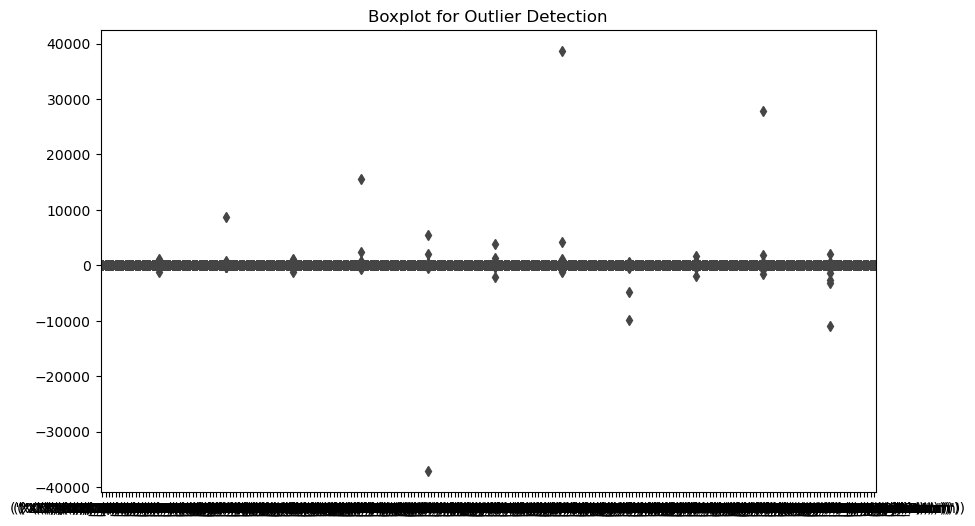

In [33]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=shifted_concatenated_df)
plt.title("Boxplot for Outlier Detection")
plt.show()

In [34]:
from scipy.stats.mstats import winsorize
shifted_concatenated_df['XLK'] = winsorize(np.array(shifted_concatenated_df['XLK']), limits=[.03, .03])
shifted_concatenated_df['XLV'] = winsorize(np.array(shifted_concatenated_df['XLV']), limits=[.03, .03])
shifted_concatenated_df['XLE'] = winsorize(np.array(shifted_concatenated_df['XLE']), limits=[.03, .03])
shifted_concatenated_df['VNQ'] = winsorize(np.array(shifted_concatenated_df['VNQ']), limits=[.03, .03])
shifted_concatenated_df['XLF'] = winsorize(np.array(shifted_concatenated_df['XLF']), limits=[.03, .03])
shifted_concatenated_df['XLB'] = winsorize(np.array(shifted_concatenated_df['XLB']), limits=[.03, .03])
shifted_concatenated_df['XLU'] = winsorize(np.array(shifted_concatenated_df['XLU']), limits=[.03, .03])
shifted_concatenated_df['XLI'] = winsorize(np.array(shifted_concatenated_df['XLI']), limits=[.03, .03])
shifted_concatenated_df['XLP'] = winsorize(np.array(shifted_concatenated_df['XLP']), limits=[.03, .03])
shifted_concatenated_df['XLY'] = winsorize(np.array(shifted_concatenated_df['XLY']), limits=[.03, .03])
shifted_concatenated_df['XTL'] = winsorize(np.array(shifted_concatenated_df['XTL']), limits=[.03, .03])

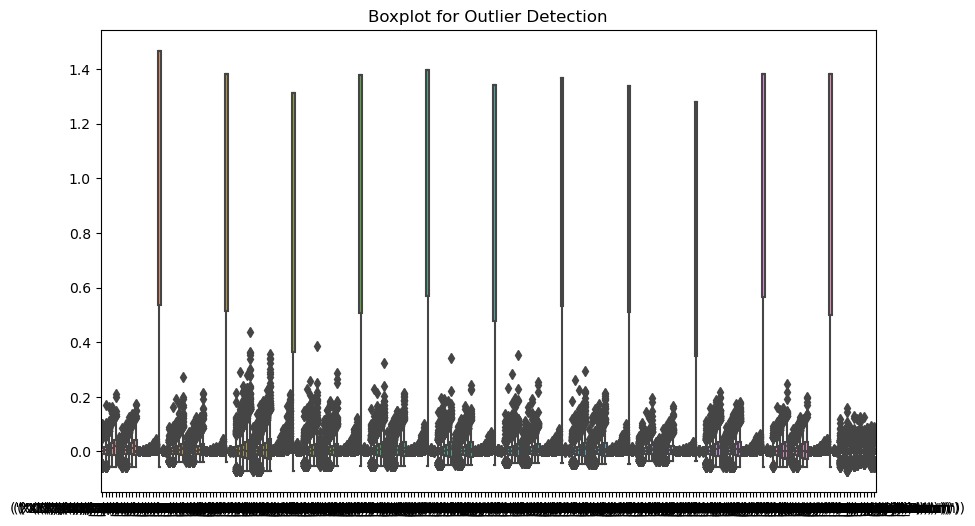

In [35]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=shifted_concatenated_df)
plt.title("Boxplot for Outlier Detection")
plt.show()

In [36]:
# Select X by dropping columns based on index positions
X = shifted_concatenated_df.drop(columns=shifted_concatenated_df.columns[day1_column_indices])

# Select y by indexing based on index positions
y = shifted_concatenated_df[('XLK', 'XLK_1Day_Return')]
# Convert any value not equal to 1 to 0
#y = y.apply(lambda x: 0 if x != 1 else 1)
y = y.apply(lambda x: 0 if x < 0 else 1)

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Define the split ratio
split_ratio = 0.8

# Calculate the split index
split_index = int(len(shifted_concatenated_df) * split_ratio)

# Split into training and testing sets
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

In [37]:
X_test.tail(50)

XLK                                                  \
           XLK_2Day_Return XLK_3Day_Return XLK_5Day_Return XLK_8Day_Return   
Date                                                                         
2024-04-12        0.003468       -0.008830       -0.004989       -0.006865   
2024-04-15       -0.034866       -0.015583       -0.022744       -0.028304   
2024-04-16       -0.017817       -0.033717       -0.026490       -0.011513   
2024-04-17       -0.013249       -0.031983       -0.028626       -0.036813   
2024-04-18       -0.025674       -0.024514       -0.055272       -0.046700   
2024-04-19       -0.031783       -0.045747       -0.055272       -0.055272   
2024-04-22       -0.011853       -0.023133       -0.036076       -0.051097   
2024-04-23        0.023892        0.002798       -0.022948       -0.055272   
2024-04-24        0.019459        0.028567       -0.004124       -0.035975   
2024-04-25        0.002384        0.017246        0.005189       -0.019452   
2024-04-26        0.009090        0.013697        0.037916       -0.009566   
2024-04-29        0.015638        0.013432        0.033153        0.009253   
2024-04-30       -0.017815       -0.006731       -0.004363       -0.001577   
2024-05-01       -0.032040       -0.027874       -0.019038        0.008986   
2024-05-02        0.004025       -0.018088       -0.002733        0.014466   
2024-05-03        0.042675        0.031997        0.013612        0.027495   
2024-05-06        0.039937        0.054926        0.021127        0.034843   
2024-05-07        0.008442        0.036537        0.040709        0.033704   
2024-05-08       -0.000439        0.011306        0.054463        0.025071   
2024-05-09        0.002546       -0.000732        0.039176        0.020380   
2024-05-10        0.003417        0.006267        0.014762        0.047231   
2024-05-13        0.008448        0.008153        0.007710        0.063060   
2024-05-14        0.013623        0.017385        0.019975        0.057241   
2024-05-15        0.031572        0.036441        0.039982        0.051740   
2024-05-16        0.018959        0.027989        0.036674        0.035915   
2024-05-17       -0.005680        0.016704        0.030554        0.037012   
2024-05-20        0.009515        0.006009        0.037771        0.046231   
2024-05-21        0.013408        0.011164        0.030335        0.048247   
2024-05-22        0.003873        0.015674        0.009905        0.046706   
2024-05-23       -0.005916       -0.004293        0.005182        0.033316   
2024-05-24        0.000232        0.002469        0.015910        0.032879   
2024-05-28        0.012700        0.004462        0.008352        0.014411   
2024-05-29       -0.002138        0.006280        0.000326        0.011494   
2024-05-30       -0.029014       -0.024908       -0.024682       -0.009395   
2024-05-31       -0.021283       -0.027487       -0.015137       -0.019364   
2024-06-03        0.004099       -0.018814       -0.020912       -0.018494   
2024-06-04        0.004616        0.006196       -0.022999       -0.018639   
2024-06-05        0.024349        0.026932        0.005076        0.011388   
2024-06-06        0.018804        0.020931        0.025116       -0.000418   
2024-06-07       -0.001019        0.021172        0.025885       -0.002314   
2024-06-10        0.004881        0.001529        0.025915        0.006613   
2024-06-11        0.021197        0.023570        0.042817        0.049278   
2024-06-12        0.041129        0.043785        0.042721        0.070803   
2024-06-13        0.030204        0.049364        0.054486        0.076558   
2024-06-14        0.011687        0.034065        0.055983        0.078340   
2024-06-17        0.018958        0.027017        0.069257        0.070892   
2024-06-18        0.016427        0.020236        0.051051        0.075825   
2024-06-20       -0.009995        0.005007        0.016753        0.061271   
2024-06-21       -0.012964       -0.011725   

## Original Data and Untuned RandomForestClassifer

In [38]:
# Instantiate the model
clf = RandomForestClassifier(random_state=1)
#clf = RandomForestClassifier(class_weight='balanced', random_state=1)

# Fit the model
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

In [39]:
# Predict using the model
train_pred = clf.predict(X_train)
test_pred = clf.predict(X_test)

In [40]:
# Check the model's balanced accuracy on the training and test sets
print('\nOriginal Data and Base RandomForestClassifer')

# Print scores
print("--------------------------------------------------------")
x = balanced_accuracy_score(y_train, train_pred)
y = balanced_accuracy_score(y_test, test_pred)
print(balanced_accuracy_score(y_train, train_pred),'training score')
print(balanced_accuracy_score(y_test, test_pred),'testing score')
print(round((x-y), 16),'variance')

# Print classification reports
print("--------------------------------------------------------")
print(f"Classification Report - Original Data")
report = classification_report(y_test, test_pred, zero_division=1)
print(report)
print("--------------------------------------------------------")


Original Data and Base RandomForestClassifer
--------------------------------------------------------
1.0 training score
0.5589815425181279 testing score
0.441018457481872 variance
--------------------------------------------------------
Classification Report - Original Data
              precision    recall  f1-score   support

           0       0.51      0.37      0.43       148
           1       0.62      0.75      0.68       205

    accuracy                           0.59       353
   macro avg       0.57      0.56      0.55       353
weighted avg       0.58      0.59      0.57       353

--------------------------------------------------------


In [41]:
# Get the feature importance array
importances = clf.feature_importances_

# List the top 10 most important features
importances_sorted = sorted(zip(clf.feature_importances_, X.columns), reverse=True)
importances_sorted

[(0.007959532498121319, ('XTL', 'XTL_2D_1D_Ratio')),
 (0.007894525999085859, ('XTL', 'XTL_3D_2D_Ratio')),
 (0.007505946540414644, ('XLE', 'XLE_2Day_Return')),
 (0.007173989171231105, ('XLF', 'XLF_2D_Squared')),
 (0.00655539751138851, ('XLV', 'XLV_2Day_Return')),
 (0.006539424426002498, ('VNQ', 'VNQ_13D_3D_Avg')),
 (0.006489580196174452, ('XLK', 'XLK_13D_Squared')),
 (0.006476154601357449, ('XLY', 'XLY_8D_Squared')),
 (0.006438789541186765, ('XLE', 'XLE_13D_Squared')),
 (0.0064107492956868885, ('XTL', 'XTL_3D_Squared')),
 (0.006329904585929057, ('XLB', 'XLB_2Day_Return')),
 (0.006309951226996272, ('XLV', 'XLV_13D_Squared')),
 (0.006195160682816365, ('XLP', 'XLP_13D_Squared')),
 (0.006120553791578483, ('XLB', 'XLB_3D_2D_Ratio')),
 (0.006112488113620173, ('XTL', 'XTL_8D_Squared')),
 (0.006061615669683913, ('XLY', 'XLY_3D_Squared')),
 (0.006035529279034923, ('XLF', 'XLF_3D_Squared')),
 (0.005987139327163909, ('XLP', 'XLP_5D_Squared')),
 (0.005950072539773045, ('XLF', 'XLF_5D_Squared')),
 (

## RandomOverSampler Data and Untuned RandomForestClassifier

In [42]:
# Import RandomOverSampler from imblearn
from imblearn.over_sampling import RandomOverSampler

# Instantiate a RandomOversampler instance
ros = RandomOverSampler(random_state=1)

In [43]:
# Fit the training data to the `RandomOverSampler` model
X_oversampled, y_oversampled = ros.fit_resample(X_train, y_train)

In [44]:
# Count distinct values
y_oversampled.value_counts()

(XLK, XLK_1Day_Return)
0    773
1    773
Name: count, dtype: int64

In [45]:
# Instantiate the model
ros_clf = RandomForestClassifier(random_state=1)

# Fit the model
ros_clf.fit(X_oversampled, y_oversampled)

RandomForestClassifier(random_state=1)

In [46]:
# Predict using the model
train_pred = ros_clf.predict(X_train)
test_pred = ros_clf.predict(X_test)

In [47]:
# Check the model's balanced accuracy on the training and test sets
print('\nRandomOverSampled Data and Untuned RandomForestClassifer')

# Print scores
print("--------------------------------------------------------")
x = balanced_accuracy_score(y_train, train_pred)
y = balanced_accuracy_score(y_test, test_pred)
print(balanced_accuracy_score(y_train, train_pred),'training score')
print(balanced_accuracy_score(y_test, test_pred),'testing score')
print(round((x-y), 16),'variance')

# Print classification reports
print("--------------------------------------------------------")
print(f"Classification Report - Original Data")
print(classification_report(y_test, test_pred))
print("--------------------------------------------------------")


RandomOverSampled Data and Untuned RandomForestClassifer
--------------------------------------------------------
1.0 training score
0.5156394199077126 testing score
0.4843605800922874 variance
--------------------------------------------------------
Classification Report - Original Data
              precision    recall  f1-score   support

           0       0.44      0.36      0.40       148
           1       0.59      0.67      0.63       205

    accuracy                           0.54       353
   macro avg       0.52      0.52      0.51       353
weighted avg       0.53      0.54      0.53       353

--------------------------------------------------------


## RandomUnderSampler Data with Untuned RandomForestClassifier

In [48]:
# Import RandomUnderSampler from imblearn
from imblearn.under_sampling import RandomUnderSampler

# Instantiate a RandomUnderSampler instance
rus = RandomUnderSampler(random_state=1)

In [49]:
# Fit the training data to the random undersampler model
X_undersampled, y_undersampled = rus.fit_resample(X_train, y_train)

In [50]:
# Count distinct values for the resampled target data
y_undersampled.value_counts()

(XLK, XLK_1Day_Return)
0    635
1    635
Name: count, dtype: int64

In [51]:
# Instantiate a new RandomForestClassier model
rus_clf = RandomForestClassifier(random_state=1)

# Fit the undersampled data the new model
rus_clf.fit(X_undersampled, y_undersampled)

RandomForestClassifier(random_state=1)

In [52]:
# Predict using the model
train_pred = rus_clf.predict(X_train)
test_pred = rus_clf.predict(X_test)

In [53]:
# Check the model's balanced accuracy on the training and test sets
print('\nRandomUnderSampled Data and Untuned RandomForestClassifer')

# Print scores
print("--------------------------------------------------------")
x = balanced_accuracy_score(y_train, train_pred)
y = balanced_accuracy_score(y_test, test_pred)
print(balanced_accuracy_score(y_train, train_pred),'training score')
print(balanced_accuracy_score(y_test, test_pred),'testing score')
print(round((x-y), 16),'variance')

# Print classification reports
print("--------------------------------------------------------")
print(f"Classification Report - Original Data")
print(classification_report(y_test, test_pred))
print("--------------------------------------------------------")


RandomUnderSampled Data and Untuned RandomForestClassifer
--------------------------------------------------------
0.9566623544631306 training score
0.5216710613052077 testing score
0.434991293157923 variance
--------------------------------------------------------
Classification Report - Original Data
              precision    recall  f1-score   support

           0       0.44      0.51      0.47       148
           1       0.60      0.54      0.57       205

    accuracy                           0.52       353
   macro avg       0.52      0.52      0.52       353
weighted avg       0.53      0.52      0.53       353

--------------------------------------------------------


## Manual Hyperparameter Tuning

In [54]:
# Try the following values for max_depth
max_depths = range(2, 30)
models = {'train_score': [], 'test_score': [], 'max_depth': []}

# Loop through each value in max_depths
for depth in max_depths:
    # Initialize the classifier with parameter variables
    clf = RandomForestClassifier(max_depth = depth, random_state=1)
    
    # Fit the data
    clf.fit(X_train, y_train)

    # Make predictions
    train_pred = clf.predict(X_train)
    test_pred = clf.predict(X_test)

    # Calculate balanced accuracy scores
    train_score = balanced_accuracy_score(y_train, train_pred)
    test_score = balanced_accuracy_score(y_test, test_pred)

    #train_score = calculate_average_balanced_accuracy(y_train_df, train_pred_df)
    #test_score = calculate_average_balanced_accuracy(y_test_df, test_pred_df)

    # Append scores
    models['train_score'].append(train_score)
    models['test_score'].append(test_score)
    models['max_depth'].append(depth)

# Create a dataframe from the models dictionary with max_depth as the index
models_df = pd.DataFrame(models).set_index('max_depth')

# Display df
display(models_df.sort_values(by='test_score', ascending=False).head(5))

,train_score,test_score
max_depth,,
23,1.0,0.566299
29,1.0,0.558982
28,1.0,0.558982
27,1.0,0.558982
26,1.0,0.558982


In [55]:
# Sort the dataframe by test_score in descending order and get the top 5
top_max_depth = models_df.sort_values(by='test_score', ascending=False).head(5).index.tolist()

# Display the top 5
top_max_depth

[23, 29, 28, 27, 26]

<Axes: xlabel='max_depth'>

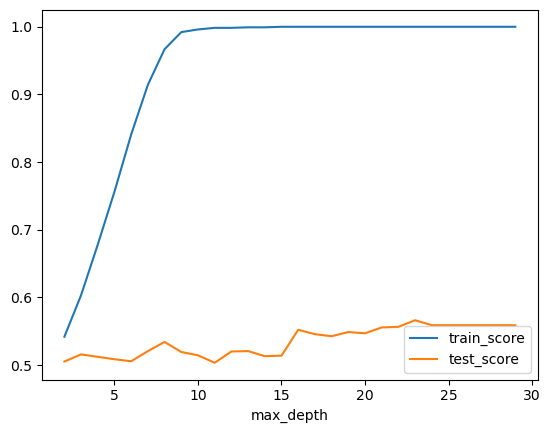

In [56]:
# Plot the results
models_df.plot()

In [57]:
# Try the following values for n_estimators
estimators = range(100, 150, 1)
models = {'train_score': [], 'test_score': [], 'n_estimators': []}

# Loop through each value in max_depths
for n in estimators:
    # Initialize the classifier with parameter variables
    clf = RandomForestClassifier(n_estimators = n, random_state=1)
    
    # Fit the data
    clf.fit(X_train, y_train)

    # Make predictions
    train_pred = clf.predict(X_train)
    test_pred = clf.predict(X_test)

    # Calculate balanced accuracy scores
    train_score = balanced_accuracy_score(y_train, train_pred)
    test_score = balanced_accuracy_score(y_test, test_pred)

    #train_score = calculate_average_balanced_accuracy(y_train_df, train_pred_df)
    #test_score = calculate_average_balanced_accuracy(y_test_df, test_pred_df)

    # Append scores
    models['train_score'].append(train_score)
    models['test_score'].append(test_score)
    models['n_estimators'].append(n)

# Create a dataframe from the models dictionary with n_estimators as the index
models_df = pd.DataFrame(models).set_index('n_estimators')

# Display df
display(models_df.sort_values(by='test_score', ascending=False).head(5))

,train_score,test_score
n_estimators,,
111,1.0,0.580175
109,1.0,0.575297
104,1.0,0.575115
112,1.0,0.571358
110,1.0,0.571358


In [58]:
# Sort the dataframe by test_score in descending order and get the top 5
top_n_estimators = models_df.sort_values(by='test_score', ascending=False).head(5).index.tolist()

# Display the top 5
top_n_estimators

[111, 109, 104, 112, 110]

<Axes: xlabel='n_estimators'>

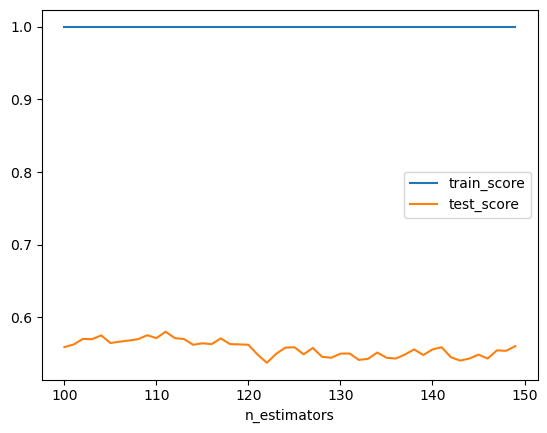

In [59]:
# Plot the results
models_df.plot()

In [60]:
# Try the following values for min_samples_leaf
min_leaf = range(2, 30)
models = {'train_score': [], 'test_score': [], 'min_samples_leaf': []}

# Loop through each value in max_depths
for min in min_leaf:
    # Initialize the classifier with parameter variables
    clf = RandomForestClassifier(min_samples_split = min, random_state=1)
    
    # Fit the data
    clf.fit(X_train, y_train)

    # Make predictions
    train_pred = clf.predict(X_train)
    test_pred =clf.predict(X_test)

    # Calculate balanced accuracy scores
    train_score = balanced_accuracy_score(y_train, train_pred)
    test_score = balanced_accuracy_score(y_test, test_pred)

    # Append scores
    models['train_score'].append(train_score)
    models['test_score'].append(test_score)
    models['min_samples_leaf'].append(min)

# Create a dataframe from the models dictionary with min_leaf as the index
models_df = pd.DataFrame(models).set_index('min_samples_leaf')

# Display df
display(models_df.sort_values(by='test_score', ascending=False).head(5))

,train_score,test_score
min_samples_leaf,,
27,0.987683,0.561025
2,1.000000,0.558982
13,0.999213,0.547709
8,0.999213,0.539074
20,0.995276,0.538514


In [61]:
# Sort the dataframe by test_score in descending order and get the top 5
top_min_samples_leaf = models_df.sort_values(by='test_score', ascending=False).head(5).index.tolist()

# Display the top 5 
top_min_samples_leaf

[27, 2, 13, 8, 20]

<Axes: xlabel='min_samples_leaf'>

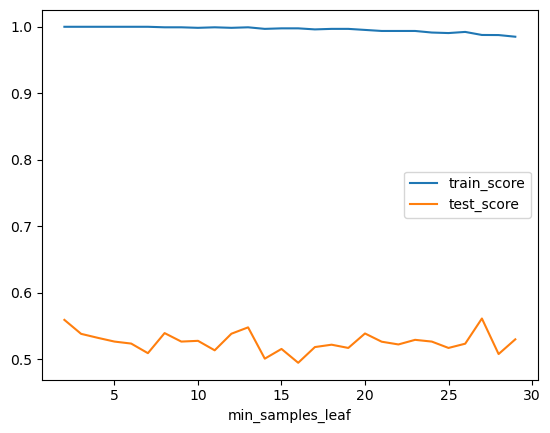

In [62]:
# Plot the results
models_df.plot()

In [63]:
# Try the following values for min_split
min_split = range(2, 30)
models = {'train_score': [], 'test_score': [], 'min_samples_split': []}

# Loop through each value in max_depths
for min in min_split:
    # Initialize the classifier with parameter variables
    clf = RandomForestClassifier(min_samples_split = min, random_state=1)
    
    # Fit the data
    clf.fit(X_train, y_train)

    # Make predictions
    train_pred = clf.predict(X_train)
    test_pred = clf.predict(X_test)

    # Calculate balanced accuracy scores
    train_score = balanced_accuracy_score(y_train, train_pred)
    test_score = balanced_accuracy_score(y_test, test_pred)

    # Append scores
    models['train_score'].append(train_score)
    models['test_score'].append(test_score)
    models['min_samples_split'].append(min)

# Create a dataframe from the models dictionary with min_split as the index
models_df = pd.DataFrame(models).set_index('min_samples_split')

# Display df
display(models_df.sort_values(by='test_score', ascending=False).head(5))

,train_score,test_score
min_samples_split,,
27,0.987683,0.561025
2,1.000000,0.558982
13,0.999213,0.547709
8,0.999213,0.539074
20,0.995276,0.538514


In [64]:
# Sort the dataframe by test_score in descending order and get the top 5
top_min_samples_split = models_df.sort_values(by='test_score', ascending=False).head(5).index.tolist()

# Display the top 5 
top_min_samples_split

[27, 2, 13, 8, 20]

<Axes: xlabel='min_samples_split'>

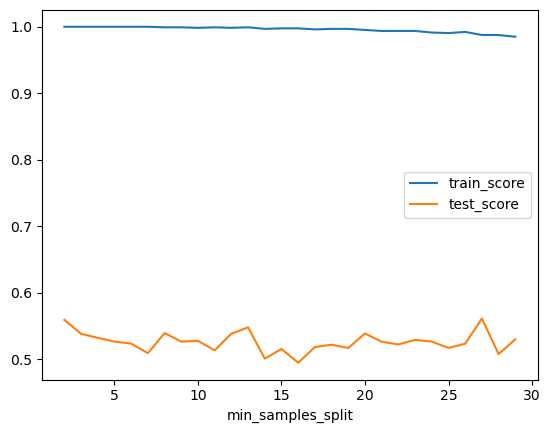

In [65]:
# Plot the results
models_df.plot()

In [66]:
# Dictionary with top 5 values for each parameter
params = {
    'n_estimators': top_n_estimators,
    'min_samples_split': top_min_samples_split,
    'max_depth': top_max_depth,
    'min_samples_leaf': top_min_samples_leaf
}

# Initialize a dictionary to store results
results = {'n_estimators': [], 'max_depth': [], 'min_samples_split': [], 'min_samples_leaf': [], 'train_score': [], 'test_score': []}

# Loop through all combinations of parameters
for n in params['n_estimators']:
    for d in params['max_depth']:
        for mss in params['min_samples_split']:
            for msl in params['min_samples_leaf']:
                # Initialize the classifier with parameter variables
                clf = RandomForestClassifier(n_estimators=n, max_depth=d, min_samples_split=mss, min_samples_leaf=msl, random_state=1)
    
                # Fit the data
                clf.fit(X_train, y_train)

                # Make predications
                train_pred = clf.predict(X_train)
                test_pred = clf.predict(X_test)

                # Calculate balanced accuracy scores
                train_score = balanced_accuracy_score(y_train, train_pred)
                test_score = balanced_accuracy_score(y_test, test_pred)

                # Append scores
                results['n_estimators'].append(n)
                results['max_depth'].append(d)
                results['min_samples_split'].append(mss)
                results['min_samples_leaf'].append(msl)
                results['train_score'].append(train_score)
                results['test_score'].append(test_score)

# Create a DataFrame from the results dictionary
results_df = pd.DataFrame(results)

In [67]:
sorted_results_df = results_df.sort_values(by='test_score', ascending=False)
print(sorted_results_df.head(5))

     n_estimators  max_depth  min_samples_split  min_samples_leaf  \
432           112         28                  2                13   
397           112         23                 20                13   
437           112         28                 13                13   
382           112         23                  2                13   
447           112         28                 20                13   

     train_score  test_score  
432     0.952531    0.554268  
397     0.952531    0.554268  
437     0.952531    0.554268  
382     0.952531    0.554268  
447     0.952531    0.554268  


In [68]:
# Initialize the classifier with parameter variables
clf = RandomForestClassifier(n_estimators=102, max_depth=23, min_samples_split=27, min_samples_leaf=9, random_state=1) 

# Fit the data
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=23, min_samples_leaf=9, min_samples_split=27,
                       n_estimators=102, random_state=1)

In [69]:
# Predict using the model
train_pred = clf.predict(X_train)
test_pred = clf.predict(X_test)

In [70]:
# Check the model's balanced accuracy on the training and test sets
print('\nRandomUnderSampled Data and Hyperparameter Tuned RandomForestClassifer')

# Print scores
print("--------------------------------------------------------")
x = balanced_accuracy_score(y_train, train_pred)
y = balanced_accuracy_score(y_test, test_pred)
print(balanced_accuracy_score(y_train, train_pred),'training score')
print(balanced_accuracy_score(y_test, test_pred),'testing score')
print(round((x-y), 16),'variance')

# Print classification reports
print("--------------------------------------------------------")
print(f"Classification Report - Original Data")
print(classification_report(y_test, test_pred))
print("--------------------------------------------------------")


RandomUnderSampled Data and Hyperparameter Tuned RandomForestClassifer
--------------------------------------------------------
0.966057185930672 training score
0.5561470006591958 testing score
0.4099101852714762 variance
--------------------------------------------------------
Classification Report - Original Data
              precision    recall  f1-score   support

           0       0.56      0.26      0.36       148
           1       0.61      0.85      0.71       205

    accuracy                           0.60       353
   macro avg       0.59      0.56      0.54       353
weighted avg       0.59      0.60      0.56       353

--------------------------------------------------------


## XGBoost Classifier

In [71]:
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor

In [72]:
# Try the following values for learning_rate
rate = np.arange(0.01, 1.1, 0.01)
models = {'train_score': [], 'test_score': [], 'learning_rate': []}

# Loop through each value in learning_rates
for r in rate:
    # Initialize the classifier with parameter variables
    xgb_clf = XGBClassifier(learning_rate = r, tree_method='approx', random_state=1)

    # Fit the data
    xgb_clf.fit(X_train, y_train)

    # Make predictions
    train_pred = xgb_clf.predict(X_train)
    test_pred = xgb_clf.predict(X_test)

    # Calculate balanced accuracy scores
    train_score = balanced_accuracy_score(y_train, train_pred)
    test_score = balanced_accuracy_score(y_test, test_pred)

    # Append scores
    models['train_score'].append(train_score)
    models['test_score'].append(test_score)
    models['learning_rate'].append(r)

# Create a dataframe from the models dictionary with learning_rate as the index
models_df = pd.DataFrame(models).set_index('learning_rate')

# Display df
display(models_df.sort_values(by='test_score', ascending=False).head(5))

KeyboardInterrupt: 

In [ ]:
# Sort the dataframe by test_score in descending order and get the top 5
top_learning_rates = models_df.sort_values(by='test_score', ascending=False).head(5).index.tolist()

# Display the top 5 
top_learning_rates

In [ ]:
# Plot the results
models_df.plot()

In [ ]:
# Try the following values for n_estimators
estimators = range(120, 150, 1)
models = {'train_score': [], 'test_score': [], 'n_estimators': []}

# Loop through each value in n_estimators
for n in estimators:
    # Initialize the classifier with parameter variables
    xgb_clf = XGBClassifier(n_estimators = n, tree_method='approx', random_state=1)

    # Fit the data
    xgb_clf.fit(X_train, y_train)

    # Make predictions
    train_pred = xgb_clf.predict(X_train)
    test_pred = xgb_clf.predict(X_test)

    # Calculate balanced accuracy scores
    train_score = balanced_accuracy_score(y_train, train_pred)
    test_score = balanced_accuracy_score(y_test, test_pred)

    # Append scores
    models['train_score'].append(train_score)
    models['test_score'].append(test_score)
    models['n_estimators'].append(n)

# Create a dataframe from the models dictionary with n_estimators as the index
models_df = pd.DataFrame(models).set_index('n_estimators')

# Display df
display(models_df.sort_values(by='test_score', ascending=False).head(5))

In [ ]:
# Sort the dataframe by test_score in descending order and get the top 5
top_n_estimators = models_df.sort_values(by='test_score', ascending=False).head(5).index.tolist()

# Display the top 5
top_n_estimators

In [ ]:
# Plot the results
models_df.plot()

In [ ]:
# Try the following values for max_depth
max_depths = range(1, 30)
models = {'train_score': [], 'test_score': [], 'max_depth': []}

# Loop through each value in max_depths
for depth in max_depths:
    # Initialize the classifier with parameter variables
    xgb_clf = XGBClassifier(max_depth = depth, tree_method='approx', random_state=1)
    
    # Fit the data
    xgb_clf.fit(X_train, y_train)

    # Make predictions
    train_pred = xgb_clf.predict(X_train)
    test_pred = xgb_clf.predict(X_test)

    # Caclulate balanced accuracy scores
    train_score = balanced_accuracy_score(y_train, train_pred)
    test_score = balanced_accuracy_score(y_test, test_pred)

    # Append scores
    models['train_score'].append(train_score)
    models['test_score'].append(test_score)
    models['max_depth'].append(depth)

# Create a dataframe from the models dictionary with max_depth as the index
models_df = pd.DataFrame(models).set_index('max_depth')

# Display df
display(models_df.sort_values(by='test_score', ascending=False).head(5))

In [ ]:
# Sort the dataframe by test_score in descending order and get the top 5
top_max_depth = models_df.sort_values(by='test_score', ascending=False).head(5).index.tolist()

# Display the top 5 
top_max_depth

In [ ]:
# Plot the results
models_df.plot()

In [ ]:
# Try the following values for max_leaves
max_leaves = range(1, 30)
models = {'train_score': [], 'test_score': [], 'max_leaves': []}

# Loop through each value in max_depths
for leaf in max_leaves:
    # Initialize the classifier with parameter variables
    xgb_clf = XGBClassifier(max_leaves = leaf, tree_method='approx', random_state=1)
    
    # Fit the data
    xgb_clf.fit(X_train, y_train)

    # Make predictions
    train_pred = xgb_clf.predict(X_train)
    test_pred = xgb_clf.predict(X_test)

    # Caclulate balanced accuracy scores
    train_score = balanced_accuracy_score(y_train, train_pred)
    test_score = balanced_accuracy_score(y_test, test_pred)

    # Append scores
    models['train_score'].append(train_score)
    models['test_score'].append(test_score)
    models['max_leaves'].append(leaf)

# Create a dataframe from the models dictionary with max_depth as the index
models_df = pd.DataFrame(models).set_index('max_leaves')

# Display df
display(models_df.sort_values(by='test_score', ascending=False).head(5))

In [ ]:
# Sort the dataframe by test_score in descending order and get the top 5
top_max_leaves = models_df.sort_values(by='test_score', ascending=False).head(5).index.tolist()

# Display the top 5
top_max_leaves

In [ ]:
# Plot the results
models_df.plot()

In [ ]:
# Try the following values for subsample
subsample = np.arange(0, 1, .01)
models = {'train_score': [], 'test_score': [], 'subsample': []}

# Loop through each value in max_depths
for sample in subsample:
    # Initialize the classifier with parameter variables
    xgb_clf = XGBClassifier(subsample = sample, tree_method='approx', random_state=1)
    
    # Fit the undersampled data the new model
    xgb_clf.fit(X_train, y_train)

    # Make predictions
    train_pred = xgb_clf.predict(X_train)
    test_pred = xgb_clf.predict(X_test)

    # Caclulate balanced accuracy scores
    train_score = balanced_accuracy_score(y_train, train_pred)
    test_score = balanced_accuracy_score(y_test, test_pred)

    # Append scores
    models['train_score'].append(train_score)
    models['test_score'].append(test_score)
    models['subsample'].append(sample)

# Create a dataframe from the models dictionary with max_depth as the index
models_df = pd.DataFrame(models).set_index('subsample')

# Display df
display(models_df.sort_values(by='test_score', ascending=False).head(5))

In [ ]:
# Sort the dataframe by test_score in descending order and get the top 5
top_subsample = models_df.sort_values(by='test_score', ascending=False).head(5).index.tolist()

# Display the top 5
top_subsample

In [ ]:
# Plot the results
models_df.plot()

In [ ]:
# Dictionary with 5 values for each parameter
params = {
    'n_estimators': top_n_estimators,
    'max_depth': top_max_depth,
    'learning_rate': top_learning_rates,
    'max_leaves': top_max_leaves,
    'subsample': top_subsample
}

# Initialize a dictionary to store results
results = {'n_estimators': [], 'max_depth': [], 'learning_rate': [],'max_leaves': [], 'subsample': [], 'train_score': [], 'test_score': []}

# Loop through all combinations of parameters
for n in params['n_estimators']:
    for d in params['max_depth']:
        for lr in params['learning_rate']:
            for ml in params['max_leaves']:
                for s in params['subsample']:
                    # Initialize the classifier with current parameters
                    xgb_clf = XGBClassifier(n_estimators=n, learning_rate=lr, max_depth=d, max_leaves=ml, subsample=s, tree_method='approx', random_state=1)
                
                    # Fit the undersampled data
                    xgb_clf.fit(X_train, y_train)
    
                    # Make predictions
                    train_pred = xgb_clf.predict(X_train)
                    test_pred = xgb_clf.predict(X_test)
    
                    # Calculate balanced accuracy scores
                    train_score = balanced_accuracy_score(y_train, train_pred)
                    test_score = balanced_accuracy_score(y_test, test_pred)
    
                    # Append results to the dictionary
                    results['n_estimators'].append(n)
                    results['max_depth'].append(d)
                    results['learning_rate'].append(lr)
                    results['max_leaves'].append(ml)
                    results['subsample'].append(s)
                    results['train_score'].append(train_score)
                    results['test_score'].append(test_score)

# Create a DataFrame from the results dictionary
results_df = pd.DataFrame(results)

In [ ]:
sorted_results_df = results_df.sort_values(by='test_score', ascending=False)
print(sorted_results_df.head(5))

In [ ]:
# For Classification
# Initialize the classifier with current parameters
xgb_clf = XGBClassifier(n_estimators=243, max_depth=20, learning_rate=.08, max_leaves=23, subsample=.97, tree_method='approx', min_split_loss=0, min_child_weight=1, random_state=1)

# Fit the undersampled data
xgb_clf.fit(X_train, y_train)

In [ ]:
# Make predictions
train_pred = xgb_clf.predict(X_train)
test_pred = xgb_clf.predict(X_test)

In [ ]:
# Check the model's balanced accuracy on the training and test sets
print('\nRandomUnderSampled Data and Tuned XGB Classifer')

# Print scores
print("--------------------------------------------------------")
x = balanced_accuracy_score(y_train, train_pred)
y = balanced_accuracy_score(y_test, test_pred)
print(balanced_accuracy_score(y_train, train_pred),'training score')
print(balanced_accuracy_score(y_test, test_pred),'testing score')
print(round((x-y), 16),'variance')

# Print classification reports
print("--------------------------------------------------------")
print(f"Classification Report - Original Data")
print(classification_report(y_test, test_pred))
print("--------------------------------------------------------")